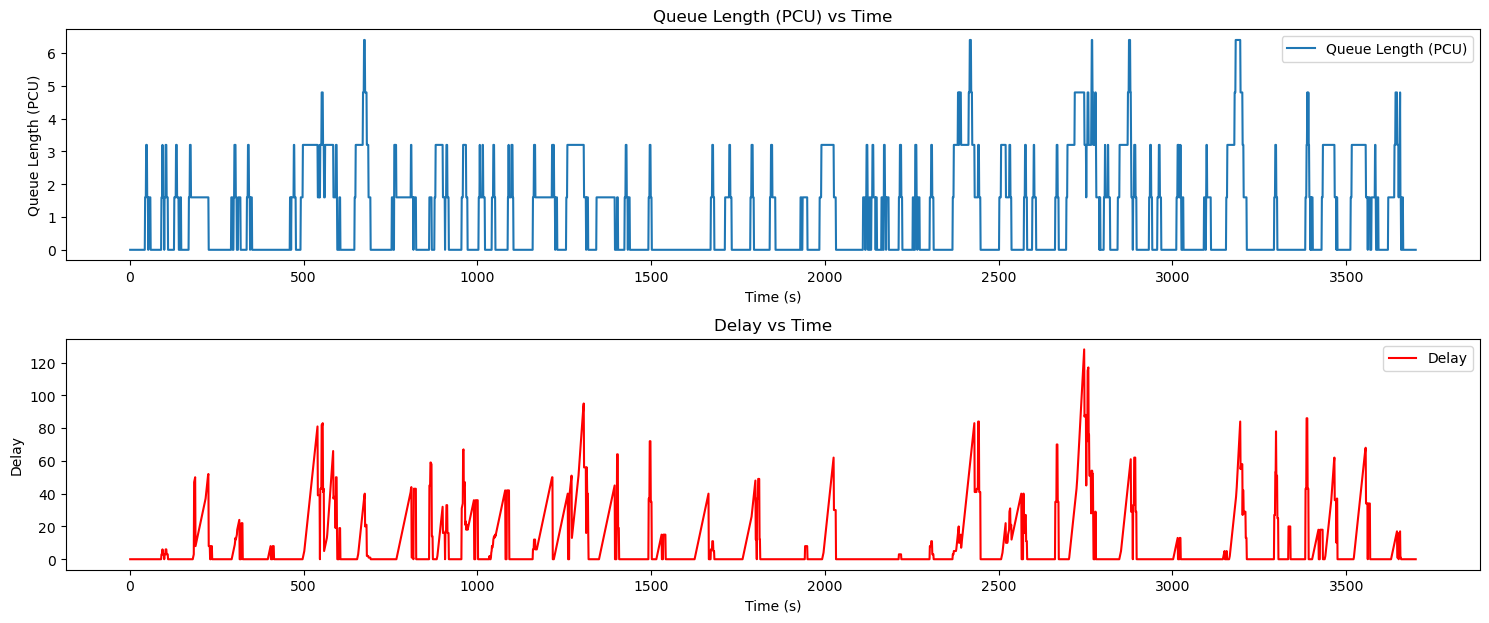

In [1]:
import pandas as pd
import traci
import matplotlib.pyplot as plt
import random
from xml.etree import ElementTree as ET
   
PCU = {
    'Car': 1,
    'truck_truck': 1.6,
    'bus_bus': 1.6,
    'MTW': 0.4,
    'veh_passenger': 0,
    'LCV': 1.1,
    'ARW': 0.5
}


def get_lane_ids(edge_id):
    return traci.edge.getLaneNumber(edge_id)

def get_queue_length_in_terms_of_PCU(edge_id):
    
    result = 0

    lane_count = traci.edge.getLaneNumber(edge_id)
    for lane_index in range(lane_count):
        lane_id = f"{edge_id}_{lane_index}"
        vehicle_ids = traci.lane.getLastStepVehicleIDs(lane_id)
        for vehicle_id in vehicle_ids:
            vehicle_type = traci.vehicle.getTypeID(vehicle_id)
            result += PCU[vehicle_type]

    return result

def compute_delay(edge_ids):
    total_delay = 0.0
    for edge_id in edge_ids:
        lane_count = get_lane_ids(edge_id)
        for lane_index in range(lane_count):
            lane_id = f"{edge_id}_{lane_index}"
            vehicle_ids = traci.lane.getLastStepVehicleIDs(lane_id)
            
            for vehicle_id in vehicle_ids:
                total_delay += traci.vehicle.getAccumulatedWaitingTime(vehicle_id)
                
    return total_delay


edge_ids = ["-35557143#0", "-1190781962#0", "1190781963#1", "42102542#1",'171423001#3']


# Start the SUMO simulation (assuming you have it set up)
sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
sumoCmd = [sumoBinary, "-c", "C:/Users/arjun/Sumo/2024-02-10-18-44-28/osm.sumocfg"]
traci.start(sumoCmd)

# Lists for plotting
times = []
queue_lengths_PCU_list = []
delays = []

while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()
    
    result = []

    current_time = traci.simulation.getTime()
    for edge_id in edge_ids:
        current_queue_length = get_queue_length_in_terms_of_PCU(edge_id)
        result.append(current_queue_length)
    queue_lengths_PCU_list.append(result)
    
    delay = compute_delay(edge_ids)
    times.append(current_time)
    delays.append(delay)
traci.close()

# Create a DataFrame
df = pd.DataFrame({
    "Time": times,
    "Queue Length (PCU)": [sum(queue) for queue in queue_lengths_PCU_list],
    "Total Queue Length (PCU)": [sum(queue) for queue in queue_lengths_PCU_list],
    "Delay": delays,
})

# Save the DataFrame to an Excel file
excel_file_path = "C:/Users/arjun/Downloads/Static.xlsx"
df.to_excel(excel_file_path, index=False)

# Plotting Queue Length, Delay
plt.figure(figsize=(15, 9))
plt.subplot(3, 1, 1)
plt.plot(times, [sum(queue) for queue in queue_lengths_PCU_list], label='Queue Length (PCU)')
plt.title('Queue Length (PCU) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Queue Length (PCU)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(times, delays, label='Delay', color='red')
plt.title('Delay vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Delay')
plt.legend()

plt.tight_layout()
plt.show()